# Detection Using Selective Search

This notebook contains the steps required for detecting ships in the geo-spatial images using Selective Search. Selective Search works by over-segmenting an image using a superpixel algorithm.

It merges superpixels in a hierarchial fashion based on 5 key points:
1. Color Similarity: Computing  a 25-bin histogram for each channel of an image. Similarity of any 2 regions is measured by the histogram intersection distance.

2. Texture Similarity: For texture, Selective Search extracts the Gaussian derivatives at 8 orientation per channel(3\*8=24). These are used to compute a 10-bin histogram. They are compared using histogram intersection distance.

3. Size Similarity: Smaller regions are grouped earlier. Hierarchial Agglomearative Clustering are prone to clusters reaching a critical mass and then combining every overlapping location.

4. Shape Similarity/compatibility: Two regions are considered compatible if they fir into each other, thereby filling gaps in the regional proposal generation.

5. Meta-similarity measure: Acts a linear combination of color, texture, size and shape similarity.

[Selective Search for Object Recognition](http://www.huppelen.nl/publications/selectiveSearchDraft.pdf)

Installing opencv-contrib as SelectiveSearch Algorithm is still not part of the official package

In [11]:
# !pip uninstall -y opencv-python

# !pip3 install opencv-contrib-python

Installing *imutils* for non-max suppression libraries

In [12]:
# !pip install imutils

# Importing the libraries

The libraries required for implementing the *Ship detection* in a geo-spatial image are imported

In [13]:
import numpy as np
import pandas as pd
import cv2, os, re
import matplotlib.pyplot as plt
import imutils

from tqdm import tqdm
from imutils.object_detection import non_max_suppression
from tensorflow.keras.models import load_model

# Utitilty Functions

1. find_regions: This method is used for finding Region of Interests(ROI) using the Selective Search Algorithm. There are 2 methods, *fast* and *quality*. The *fast* methods finds the ROI faster but with lesser quality, whie the *quality* finds more ROI at a cost of more time spent

2. load_scenes: Load the geospatial images into a list for object detection.

In [14]:
def find_regions(image, method):

    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)

    if method == 'fast':
        ss.switchToSelectiveSearchFast()
    else:
        ss.switchToSelectiveSearchQuality()

    rects = ss.process()
    boxes = []
    for (x,y,w,h) in rects:

        boxes.append([x,y,w,h])
        pass

    return boxes
    pass

In [15]:
scene_path = '../../data_copy/data_test'

def load_scenes():

    scenes = []
    dirfiles = os.listdir(scene_path)
    dirfiles = sorted(dirfiles)
    for file in dirfiles:

        print(os.path.join(scene_path, file))
        scene = cv2.imread(os.path.join(scene_path, file))
        scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
        scenes.append(scene)
        pass

    return scenes
    pass

In [16]:
scenes = load_scenes()

../../data_copy/data_test/berlin.PNG
../../data_copy/data_test/madrid.PNG
../../data_copy/data_test/ny.PNG
../../data_copy/data_test/paris.PNG
../../data_copy/data_test/scene_1.png
../../data_copy/data_test/scene_2.png
../../data_copy/data_test/scene_3.png
../../data_copy/data_test/scene_4.png


In [17]:
type(scenes[1])

numpy.ndarray

# Finding ROIs

The Region of Interests(ROIs) are found for each loaded scene, depending on the method used, the time taken varies along with the detection. For countering this, it is better to create a feature map of the scene and then finding the ROIs.

1. Fast -> 17min 28s

2. Quality -> 3h 8min 49s

To change the type of detection, change the *method* variable. Options:
```
fast
quality
```

In [18]:
%%time
method = "fast"

boxes = []

for scene in scenes:

    box_in_scene = find_regions(scene, method)
    boxes.append(box_in_scene)
    pass

CPU times: user 3min 56s, sys: 5.69 s, total: 4min 2s
Wall time: 3min 23s


In [19]:
type(boxes)

list

# Loading Saved Model

The model trained in [Ship Detection using Faster R-CNN: Part 1](https://www.kaggle.com/apollo2506/ship-detection-using-faster-r-cnn) on the dataset is loaded along with the weights obtained from the model. The current model is based upon the class weights. For the model based upon augmentation, Part 1 will have to be run with **AUGMENTATION** set to *True*.

In [20]:
model = load_model('ship-model.h5')

model.summary()

2024-03-13 16:17:52.309997: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/cv2/../../lib64:
2024-03-13 16:17:52.310156: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-03-13 16:17:52.310263: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (UTILISA-O4KTAUM): /proc/driver/nvidia/version does not exist
2024-03-13 16:17:52.311310: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "Feature_Extraction_and_FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 20, 3)]       0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 30, 30, 3)        0         
 ng2D)                                                           
                                                                 
 conv1 (Conv2D)              (None, 15, 15, 16)        448       
                                                                 
 bn_conv1 (BatchNormalizatio  (None, 15, 15, 16)       64        
 n)                                                              
                                                                 
 conv_2A_branch2a (Conv2D)   (None, 15, 15, 32)        4640      
                                                                 
 bn_2A_branch2a (BatchNormal  (None, 15, 

# Predicting the ROIs

The ROIs for each scene are taken and run through the model. ROIs with scaling factor greater than 0.10 are ignored as they are to be big for the and lead to uncessary ROIs being predicted. The scaling factor in an ideal situation should vary between 0.10 and 0.15, as they are the sweet spots, where a ship inside a ROI but not an entire city block.

Bounding boxes are drawn around each detected object if it is classified as a ship, otherwise not. The resulting images are stored in the *images* list for displaying.

In [21]:
type(scenes)
bob = list(enumerate(scenes))[4]
print(type(bob))
i, scene = bob

<class 'tuple'>


In [24]:
scene

array([[[216, 189, 158],
        [214, 189, 160],
        [208, 183, 156],
        ...,
        [ 61,  71,  52],
        [ 57,  68,  49],
        [ 59,  70,  50]],

       [[204, 179, 149],
        [205, 180, 151],
        [196, 171, 141],
        ...,
        [ 59,  69,  50],
        [ 54,  63,  45],
        [ 59,  69,  49]],

       [[196, 172, 141],
        [205, 178, 152],
        [191, 164, 137],
        ...,
        [ 61,  72,  53],
        [ 52,  62,  43],
        [ 54,  66,  46]],

       ...,

       [[119, 109,  82],
        [ 94,  86,  63],
        [103,  91,  70],
        ...,
        [108,  94,  71],
        [109,  94,  71],
        [117,  99,  78]],

       [[ 88,  79,  53],
        [ 60,  55,  35],
        [ 60,  54,  38],
        ...,
        [110,  96,  73],
        [106,  93,  70],
        [111,  97,  76]],

       [[ 85,  74,  49],
        [ 64,  59,  37],
        [ 66,  60,  39],
        ...,
        [110,  96,  72],
        [104,  91,  69],
        [111,  97,  77]]

In [88]:
%%time

del rois[:]
del locs[:]

rois, locs = [], []
images = []

(H, W) = scene.shape[:2]
region, loc = [],[]

compt_roi = 0
for (x,y,w,h) in boxes[i]:

    if w/float(W) > 0.10 and h/float(H) > 0.10:
        continue
    compt_roi = compt_roi + 1
    roi = scene[y:y+h,x:x+w]
    roi = cv2.cvtColor(roi,cv2.COLOR_BGR2RGB)
    roi = cv2.resize(roi, (20,20))
    roi = np.array(list(map(lambda x : x/255,roi)))

    rois.append(roi)
    locs.append((x,y,x+w,y+h))
    pass

preds = model.predict(np.array(rois,dtype=np.float32))
preds2 = np.argmax(preds, axis=1)

compt_detected = 0

img = scene.copy()
for (i,label) in enumerate(preds2):

    if label == 1:
        compt_detected = compt_detected + 1
        (startX,startY,endX,endY) = locs[i]
        cv2.rectangle(img,(startX,startY),(endX,endY),(0,255,0),2)
    pass

images.append(img)


CPU times: user 2.05 s, sys: 214 ms, total: 2.26 s
Wall time: 1.42 s


In [83]:
def labelisator(x):

    mat = []

    for i in x :
        y = 0
        a, b = i
        if a < b :
            y = 1
        mat.append(y)
    return mat

In [89]:
bib = labelisator(preds)

In [90]:
sum(bib)

104

In [57]:
bob = np.array(rois,dtype=np.float32)

In [58]:
bob.shape

(694, 20, 20, 3)

In [24]:
boby = bob[1]

In [25]:
boby.shape

(20, 20, 3)

In [38]:
boby

array([[[166., 191., 225.],
        [167., 194., 228.],
        [168., 194., 228.],
        ...,
        [183., 207., 240.],
        [172., 198., 230.],
        [177., 203., 235.]],

       [[166., 191., 225.],
        [169., 195., 228.],
        [171., 196., 230.],
        ...,
        [175., 199., 232.],
        [170., 196., 228.],
        [188., 213., 245.]],

       [[172., 197., 229.],
        [176., 200., 232.],
        [178., 202., 234.],
        ...,
        [180., 204., 236.],
        [174., 199., 232.],
        [187., 211., 242.]],

       ...,

       [[181., 205., 233.],
        [191., 214., 242.],
        [205., 224., 252.],
        ...,
        [186., 211., 237.],
        [186., 211., 235.],
        [200., 222., 247.]],

       [[194., 217., 245.],
        [198., 221., 249.],
        [192., 213., 243.],
        ...,
        [196., 219., 242.],
        [206., 227., 250.],
        [213., 233., 255.]],

       [[195., 216., 244.],
        [192., 215., 245.],
        [163., 1

In [51]:
x = np.array([1, 2, 3, 4, 5])
def f(y):
    return y/255
# Obtain array of square of each element in x

z = np.array(list(map(f,boby)))
z

array([[[0.6509804 , 0.7490196 , 0.88235295],
        [0.654902  , 0.7607843 , 0.89411765],
        [0.65882355, 0.7607843 , 0.89411765],
        ...,
        [0.7176471 , 0.8117647 , 0.9411765 ],
        [0.6745098 , 0.7764706 , 0.9019608 ],
        [0.69411767, 0.79607844, 0.92156863]],

       [[0.6509804 , 0.7490196 , 0.88235295],
        [0.6627451 , 0.7647059 , 0.89411765],
        [0.67058825, 0.76862746, 0.9019608 ],
        ...,
        [0.6862745 , 0.78039217, 0.9098039 ],
        [0.6666667 , 0.76862746, 0.89411765],
        [0.7372549 , 0.8352941 , 0.9607843 ]],

       [[0.6745098 , 0.77254903, 0.8980392 ],
        [0.6901961 , 0.78431374, 0.9098039 ],
        [0.69803923, 0.7921569 , 0.91764706],
        ...,
        [0.7058824 , 0.8       , 0.9254902 ],
        [0.68235296, 0.78039217, 0.9098039 ],
        [0.73333335, 0.827451  , 0.9490196 ]],

       ...,

       [[0.70980394, 0.8039216 , 0.9137255 ],
        [0.7490196 , 0.8392157 , 0.9490196 ],
        [0.8039216 , 0

In [35]:
boby[0][0][0]

166.0

In [40]:
bobo = boby[0][0]
bobo

array([166., 191., 225.], dtype=float32)

In [37]:
type(boby[0][0][0])

numpy.float32

In [48]:
bo = boby.astype(np.int32)

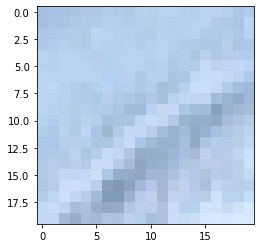

In [52]:
plt.imshow(z)

In [51]:
compt_detected

694

In [68]:
preds.shape

(950, 2)

In [65]:
preds

array([[9.9992537e-01, 7.4647505e-05],
       [9.9979597e-01, 2.0406340e-04],
       [9.9581909e-01, 4.1809017e-03],
       ...,
       [9.9986827e-01, 1.3169317e-04],
       [9.8758346e-01, 1.2416521e-02],
       [9.9999988e-01, 1.3853789e-07]], dtype=float32)

In [60]:
test_pred = np.argmax(preds,axis=1)

In [71]:
preds2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [67]:
preds2.shape

(950,)

In [1]:
type(images[0])

NameError: name 'images' is not defined

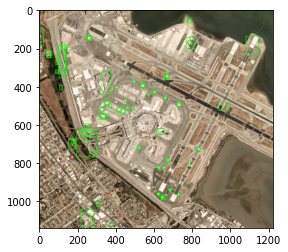

In [86]:
plt.imshow(images[0])
plt.show();

In [91]:
%%time

rois, locs = [], []
images = []
for i,scene in tqdm(enumerate(scenes)):

    (H, W) = scene.shape[:2]
    region, loc = [],[]
    for (x,y,w,h) in boxes[i]:

        if w/float(W) > 0.10 and h/float(H) > 0.10:
            continue

        roi = scene[y:y+h,x:x+w]
        roi = cv2.cvtColor(roi,cv2.COLOR_BGR2RGB)
        roi = cv2.resize(roi, (20,20))
        roi = np.array(list(map(lambda x : x/255,roi)))

        rois.append(roi)
        locs.append((x,y,x+w,y+h))
        pass

    preds = model.predict(np.array(rois,dtype=np.float32))
    preds = np.argmax(preds, axis=1)

    img = scene.copy()
    for (i,label) in enumerate(preds):

        if label == 1:
            (startX,startY,endX,endY) = locs[i]
            cv2.rectangle(img,(startX,startY),(endX,endY),(0,255,0),2)
        pass

    images.append(img)
    del rois[:]
    del locs[:]
    pass

0it [00:00, ?it/s]

8it [00:12,  1.51s/it]

CPU times: user 18.2 s, sys: 2.01 s, total: 20.2 s
Wall time: 12.1 s


# Displaying final Images

The final images containing the predicted bounding boxes are displayed in the next code block.

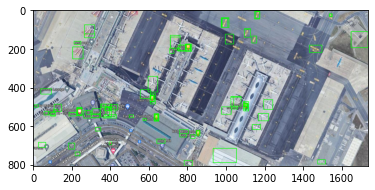

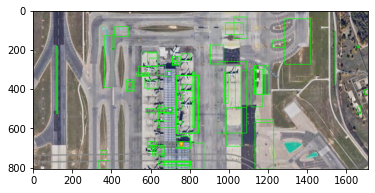

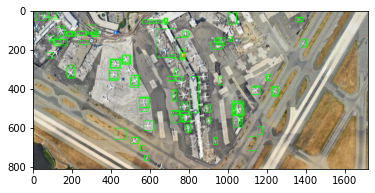

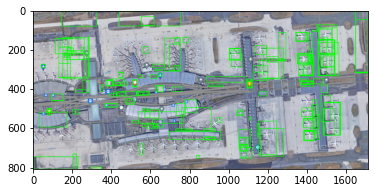

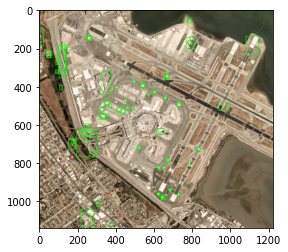

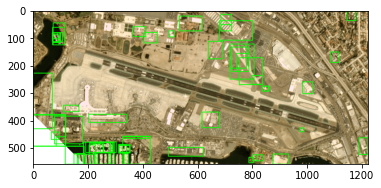

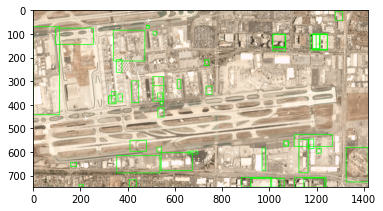

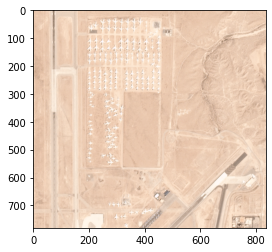

In [92]:
for image in images:

    plt.imshow(image)
    plt.show();

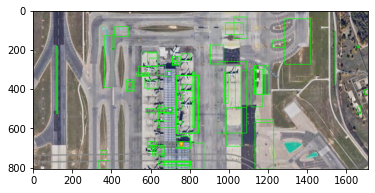

In [93]:
plt.imshow(images[1])
plt.show()